<a href="https://colab.research.google.com/github/sumitgiri6581/Stockprice/blob/main/stockpp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing** **Libraries**







In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import os
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

**Loading and Inspecting Data**

In [15]:
data = pd.read_csv('all_stocks_5yr.csv', delimiter=',', on_bad_lines='skip')
print(data.shape)
print(data.sample(7))

(619040, 7)
              date    open      high      low   close    volume  Name
321372  2017-05-16   41.11   41.1100   40.280   40.64   4629096   JWN
327969  2015-12-18   15.37   15.6018   15.010   15.14  59706528   KMI
414045  2013-12-31  114.25  114.7800  113.850  114.61    965800   NOC
474643  2017-11-02   72.46   72.7755   72.010   72.25   4535638  PYPL
222823  2014-11-03   37.34   37.5000   37.190   37.45   2539649    FE
169534  2015-08-20   65.26   65.3450   63.151   63.27   2228982  DISH
184812  2015-01-09   77.55   77.6840   76.213   76.50   1815059     D


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB


**Data** **Cleaning**

In [17]:
data['date'] = pd.to_datetime(data['date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619040 non-null  datetime64[ns]
 1   open    619029 non-null  float64       
 2   high    619032 non-null  float64       
 3   low     619032 non-null  float64       
 4   close   619040 non-null  float64       
 5   volume  619040 non-null  int64         
 6   Name    619040 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 33.1+ MB


**Visualization**

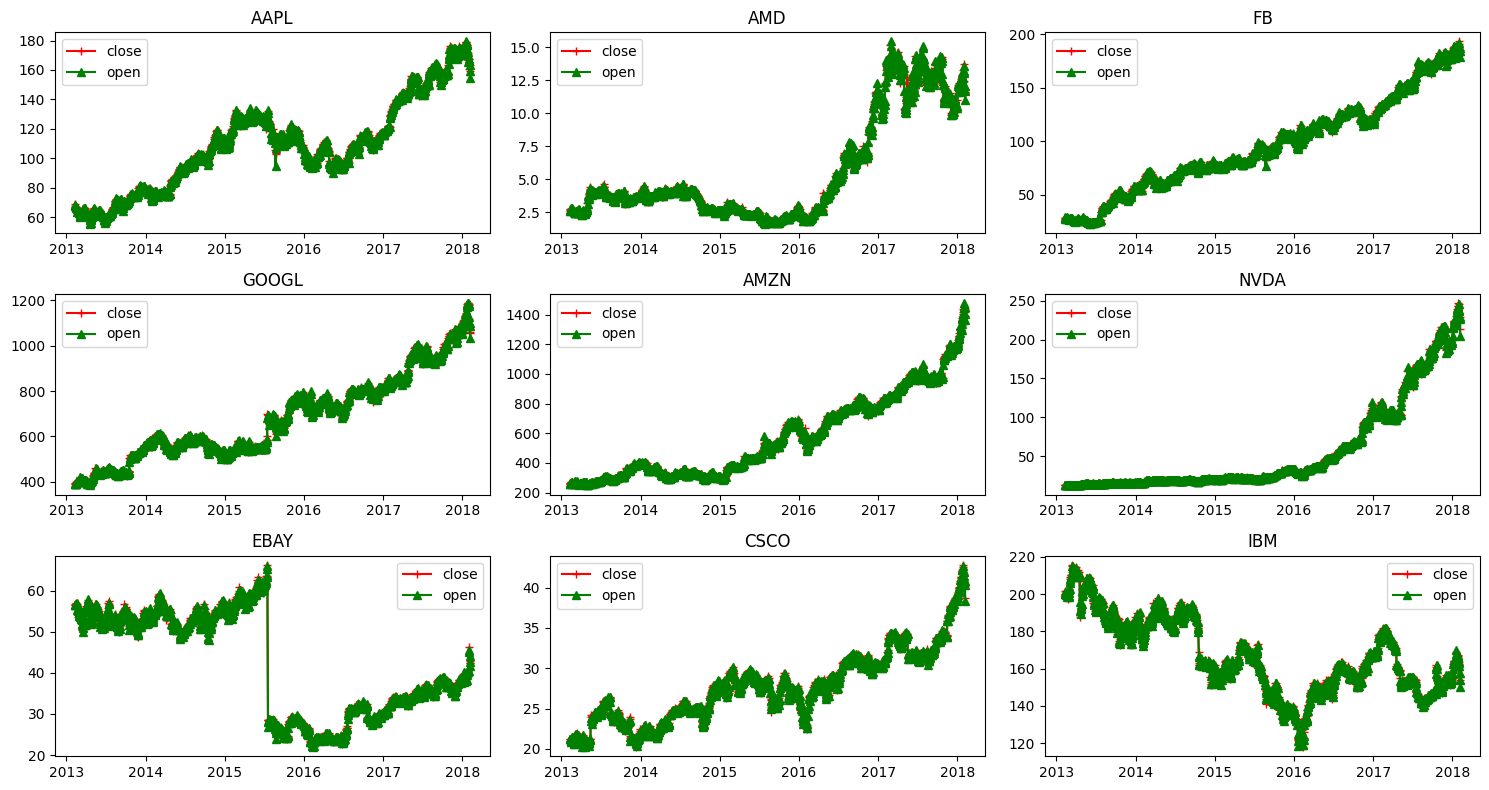

In [18]:
data['date'] = pd.to_datetime(data['date'])
# date vs open
# date vs close

# Define the list of companies you want to plot
companies = ['AAPL', 'AMD', 'FB', 'GOOGL', 'AMZN', 'NVDA', 'EBAY', 'CSCO', 'IBM']

plt.figure(figsize=(15, 8))
for index, company in enumerate(companies, 1):
	plt.subplot(3, 3, index)
	c = data[data['Name'] == company]
	plt.plot(c['date'], c['close'], c="r", label="close", marker="+")
	plt.plot(c['date'], c['open'], c="g", label="open", marker="^")
	plt.title(company)
	plt.legend()
	plt.tight_layout()

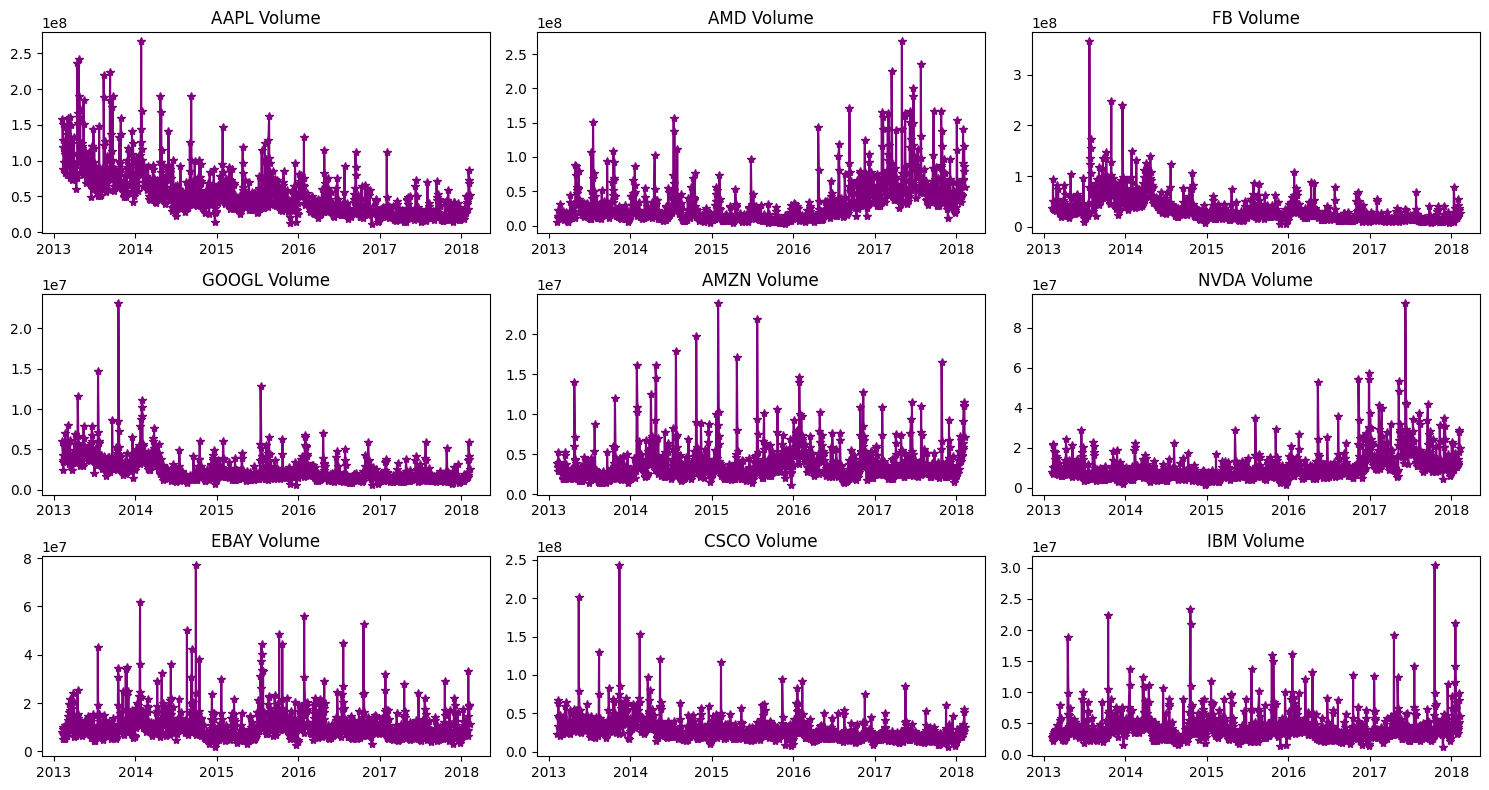

In [19]:
plt.figure(figsize=(15, 8))
for index, company in enumerate(companies, 1):
	plt.subplot(3, 3, index)
	c = data[data['Name'] == company]
	plt.plot(c['date'], c['volume'], c='purple', marker='*')
	plt.title(f"{company} Volume")
	plt.tight_layout()

**Focusing on Apple**

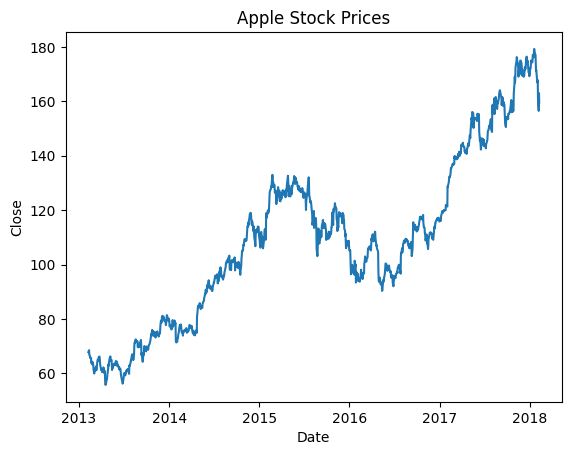

In [20]:
apple = data[data['Name'] == 'AAPL']
prediction_range = apple.loc[(apple['date'] > datetime(2013,1,1))
& (apple['date']<datetime(2018,1,1))]
plt.plot(apple['date'],apple['close'])
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Apple Stock Prices")
plt.show()

 **Data Preparation for LSTM**

In [23]:
close_data = apple.filter(['close'])
dataset = close_data.values
training = int(np.ceil(len(dataset) * .95))
print(training)

1197


In [25]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:int(training), :]
# prepare feature and labels
x_train = []
y_train = []

for i in range(60, len(train_data)):
	x_train.append(train_data[i-60:i, 0])
	y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

**Building and Training the LSTM Model**

In [26]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64,
							return_sequences=True,
							input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
model.summary

<bound method Model.summary of <Sequential name=sequential_1, built=True>>

In [ ]:
model.compile(optimizer='adam',
			loss='mean_squared_error')
history = model.fit(x_train,
					y_train,
					epochs=10)

**Model Evaluation and Prediction**

In [27]:
test_data = scaled_data[training - 60:, :]
x_test = []
y_test = dataset[training:, :]
for i in range(60, len(test_data)):
	x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# predict the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# evaluation metrics
mse = np.mean(((predictions - y_test) ** 2))
print("MSE", mse)
print("RMSE", np.sqrt(mse))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step
MSE 10930.498905865077
RMSE 104.54902632671946


**Visualization of Predictions**

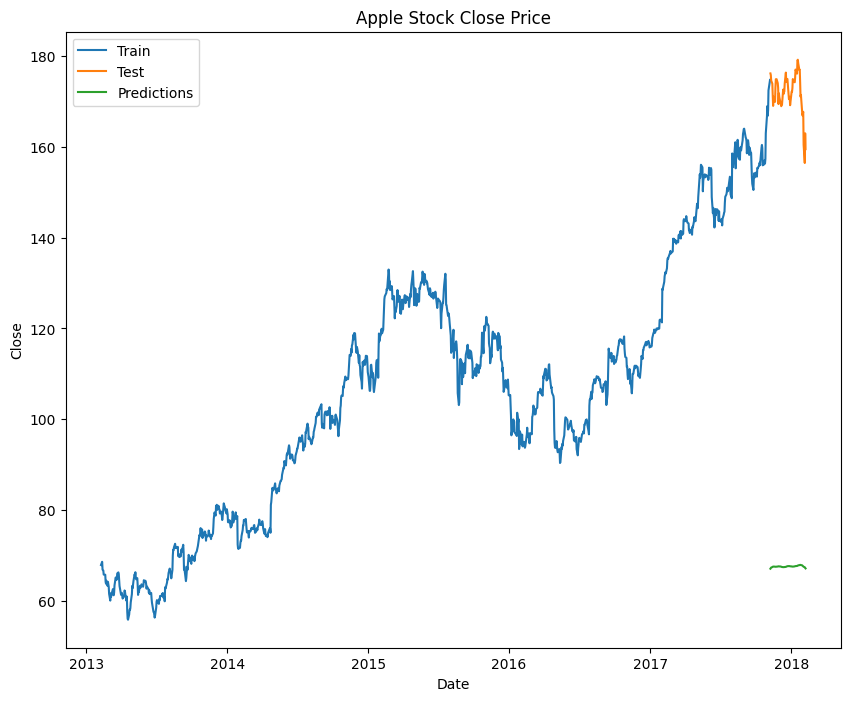

In [28]:
train = apple[:training]
test = apple[training:]
test['Predictions'] = predictions

plt.figure(figsize=(10, 8))
plt.plot(train['date'], train['close'])
plt.plot(test['date'], test[['close', 'Predictions']])
plt.title('Apple Stock Close Price')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test', 'Predictions'])

**Predicting Future Price**

In [34]:
# Assuming your model and scaler are already trained

# Get the last 60 days of closing prices from the training data
last_60_days = train_data[-60:]

# Reshape the data for the LSTM model
last_60_days = last_60_days.reshape(1, 60, 1)

# Make the prediction
prediction = model.predict(last_60_days)

# Inverse transform the prediction
predicted_price = scaler.inverse_transform(prediction)[0][0]

# Get the actual date for the prediction
prediction_date = apple['date'].iloc[training]

print(f"Predicted closing price for Apple on {prediction_date.date()}: {predicted_price:.2f}")

# Get the actual closing price for that date
actual_price = apple['close'].iloc[training]

print(f"Actual closing price for Apple on {prediction_date.date()}: {actual_price:.2f}")

# Calculate the difference
difference = predicted_price - actual_price

print(f"Difference: {difference:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted closing price for Apple on 2017-11-08: 67.04
Actual closing price for Apple on 2017-11-08: 176.24
Difference: -109.20
